## Run Network
Script for using existing network to run on cohort data

In [1]:
import os
import numpy as np
from deepcell.model_zoo import bn_feature_net_2D, bn_feature_net_2D
import matplotlib.pyplot as plt
import xarray as xr
import math

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
# load data
data_dir = '/data/shirley/test_points/'
cohort_xr = xr.load_dataarray(data_dir + 'Deepcell_Input_Membrane.nc')

In [3]:
# load model
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'Decidua_Shirley_Relabel_Ir_Train_61_rf_512_dense_128_conv_epoch_03.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [5]:
run_sample_model = bn_feature_net_2D(
    n_dense_filters=512,
    n_conv_filters=128,
    dilated=True,
    n_features=3,
    norm_method='std',
    receptive_field=61,
    n_channels=1,    
    input_shape=(1124, 1124, 4))

run_sample_model.load_weights(weights_path)

In [6]:
output_array = np.zeros((cohort_xr.shape[:3] + (3,)), dtype='float32')

In [7]:
# can't load entire image at once into memory, subset into slightly overlapping regions and run through
for i in range(cohort_xr.shape[0]):
    print("predicting point {}".format(i))
    output_array[i, :1024, :1024, :] = run_sample_model.predict(cohort_xr.values[i:(i + 1), :1124, :1124, :])[:, :1024, :1024, :]
    output_array[i, :1024, 1024:, :] = run_sample_model.predict(cohort_xr.values[i:(i + 1), :1124, 924:, :])[:, :1024, 100:, :]
    output_array[i, 1024:, :1024, :] = run_sample_model.predict(cohort_xr.values[i:(i + 1), 924:, :1124, :])[:, 100:, :1024, :]
    output_array[i, 1024:, 1024:, :] = run_sample_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[:, 100:, 100:, :]
    

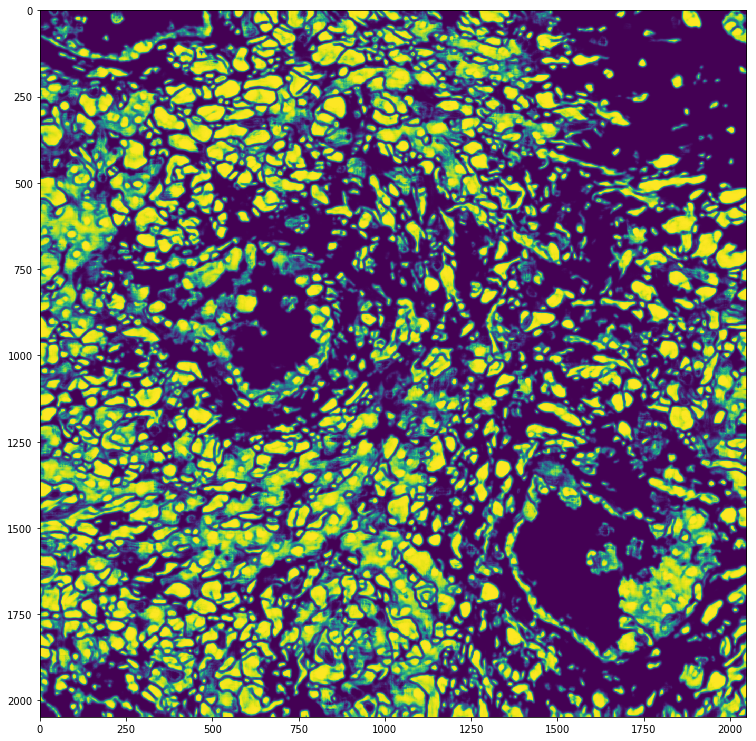

In [12]:
plt.figure(figsize = (13, 13))
plt.imshow(output_array[3, :, :, 1])

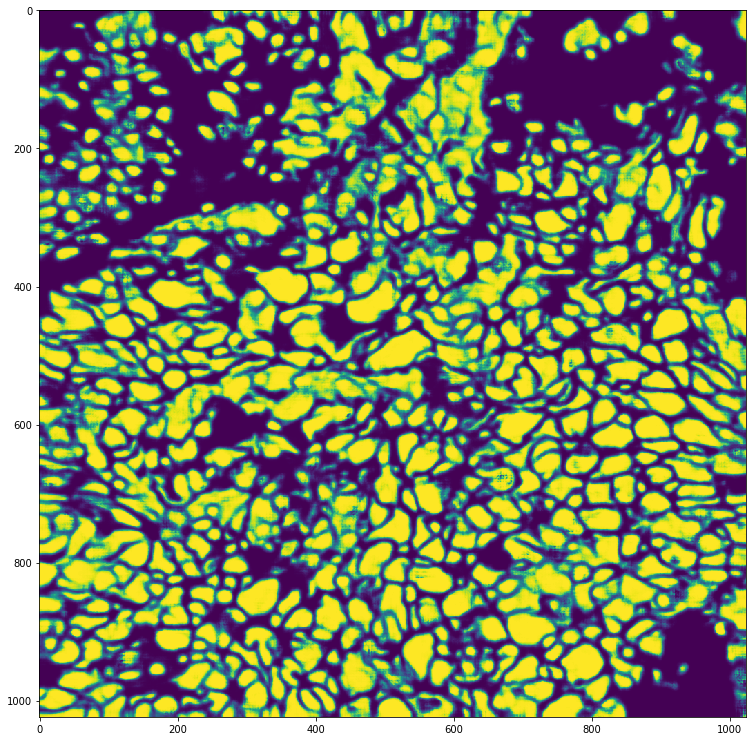

In [9]:
plt.figure(figsize = (13, 13))
plt.imshow(output_array[4, :, :, 1])

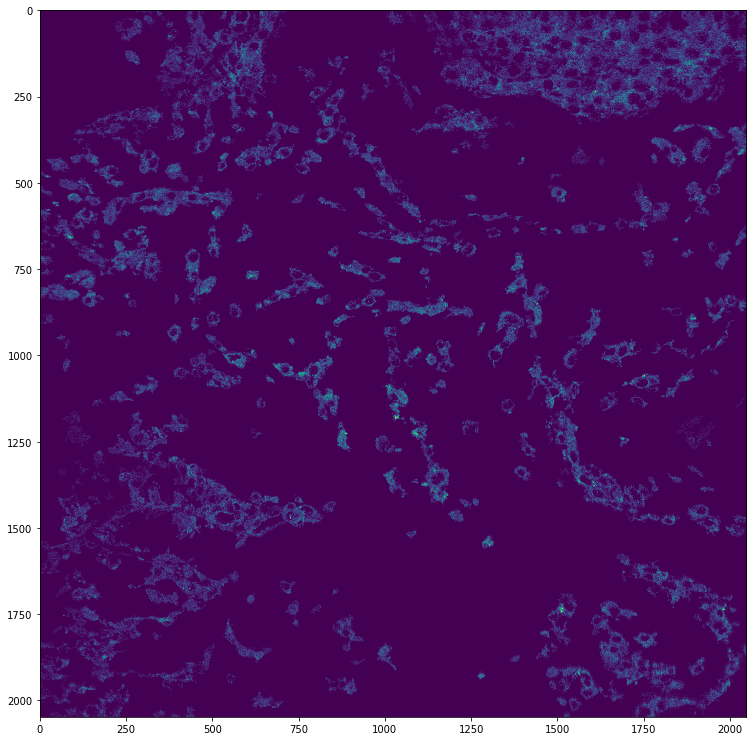

In [61]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr.values[4, :, :, 2])

In [67]:
xr_output = xr.DataArray(output_array,
                         coords=[cohort_xr.coords['points'], range(2048), range(2048), ['border', 'interior', 'bg']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join(data_dir, "deepcell_output.nc"), format="NETCDF3_64BIT")

# Run watershed network

In [70]:
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'Decidua_Shirley_Relabel_Train_watershed_61_rf_256_dense_64_conv_2erosion_epoch_04.h5'
watershed_weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [78]:
run_watershed_model = bn_feature_net_2D(
    dilated=True,
    receptive_field=61,
    n_features=4,
    input_shape=(1124, 1124, 3), 
    n_conv_filters=64,
    n_dense_filters=256)
run_watershed_model.load_weights(watershed_weights_path)

In [79]:
output_array_watershed = np.zeros((cohort_xr.shape[:3] + (4,)))

In [80]:
# can't load entire image at once into memory, subset into slightly overlapping regions and run through
for i in range(cohort_xr.shape[0]):
    output_array_watershed[i, :1024, :1024, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), :1124, :1124, :])[:, :1024, :1024, :]
    output_array_watershed[i, :1024, 1024:, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), :1124, 924:, :])[:, :1024, 100:, :]
    output_array_watershed[i, 1024:, :1024, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), 924:, :1124, :])[:, 100:, :1024, :]
    output_array_watershed[i, 1024:, 1024:, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[:, 100:, 100:, :]
    

In [81]:
argmax_images = []
for j in range(output_array_watershed.shape[0]):
    argmax_images.append(np.argmax(output_array_watershed[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

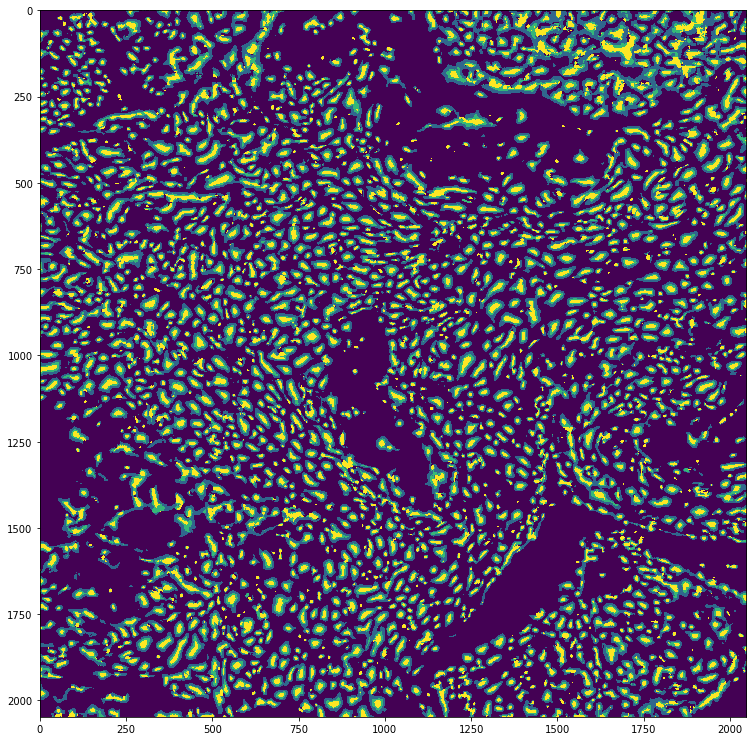

In [84]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[4, :, :])

In [85]:
xr_output_watershed = xr.DataArray(output_array_watershed,
                         coords=[cohort_xr.coords['points'], range(2048), range(2048), ['level_0', 'level_1', 'level_2', 'level_3']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output_watershed.to_netcdf(os.path.join(data_dir, "watershed_output2.nc"), format="NETCDF3_64BIT")